<a href="https://colab.research.google.com/github/jeawonlll/QuantileReg/blob/main/20230601_QuantileReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QauntileReg - MagicBricks

---

*   https://jonsyou.tistory.com/14
*   https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/



In [ ]:
import os
from google.colab import drive  # for colab
drive.mount('/content/gdrive/')  # for colab
cloud_directory = '/content/gdrive/MyDrive/cdw_temp/'
os.listdir(cloud_directory) # for colab, check cloud directory mount

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


['cardio_ft_202212131338.csv',
 'ft_20230414_survival_202304141738.csv',
 'FT24_result.csv',
 'MagicBricks.csv']

In [ ]:
! pip install numpy
! pip install pandas
! pip install statsmodels
! pip install matplotlib
! pip install seaborn
# ! pip install kaggle
# https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1.1.Data Prep

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
house_data = pd.read_csv('/content/gdrive/MyDrive/cdw_temp/MagicBricks.csv')

In [ ]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Area         1259 non-null   float64
 1   BHK          1259 non-null   int64  
 2   Bathroom     1257 non-null   float64
 3   Furnishing   1254 non-null   object 
 4   Locality     1259 non-null   object 
 5   Parking      1226 non-null   float64
 6   Price        1259 non-null   int64  
 7   Status       1259 non-null   object 
 8   Transaction  1259 non-null   object 
 9   Type         1254 non-null   object 
 10  Per_Sqft     1018 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 108.3+ KB


## 1.2. Analysis

### 1.2.1. Regression

In [ ]:
X = house_data[['Area']]
y = house_data['Price']

In [ ]:
from sklearn.linear_model import LinearRegression
lm_model = LinearRegression()
lm_model.fit(X,y)
y_pred = lm_model.predict(X)

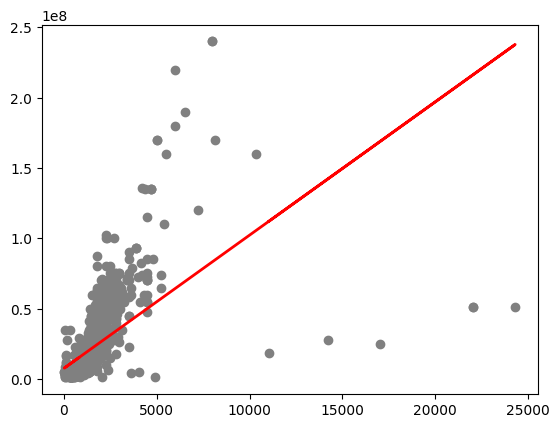

In [ ]:
plt.scatter(X['Area'], y, color ='gray')
plt.plot(X['Area'], y_pred, color ='red', linewidth=2)
plt.show()

### 1.2.2. Quantile Regression

In [ ]:
mod = smf.quantreg('Price ~ Area', house_data)

In [ ]:
quantiles = np.arange(.05,.96,.1) # quantiles = [.05,.15,.25,...,.95]

In [ ]:
quantiles = np.arange(.05,.96,.1) # quantiles = [.05,.15,.25,...,.95]

def fit_model(q):
  res = mod.fit(q=q)
  return [q, res.params['Intercept'], res.params['Area']] + \
  res.conf_int().loc['Area'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [ ]:
ols = smf.ols('Price ~ Area', house_data).fit()
ols_ci = ols.conf_int().loc['Area'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['Area'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q             a             b            lb            ub
0  0.05  8.636895e-02   2098.765429   1481.475601   2716.055257
1  0.15 -6.783116e+05   6396.247894   5969.242836   6823.252951
2  0.25 -3.508403e+06  11484.593838  11174.694777  11794.492899
3  0.35 -4.735484e+06  14301.075269  14004.946566  14597.203972
4  0.45 -5.759494e+06  16835.443038  16549.306418  17121.579657
5  0.55 -6.103448e+06  18773.946360  18502.266094  19045.626627
6  0.65 -6.947059e+06  21529.411765  21244.858078  21813.965452
7  0.75 -6.649025e+06  23286.908087  22965.450320  23608.365854
8  0.85 -7.408257e+06  27522.935780  27097.072319  27948.799241
9  0.95 -1.727354e+06  30215.919304  28593.623289  31838.215320
{'a': 7400145.699394266, 'b': 9483.127416756279, 'lb': 8747.712271676224, 'ub': 10218.542561836333}


## 1.3. Plotting

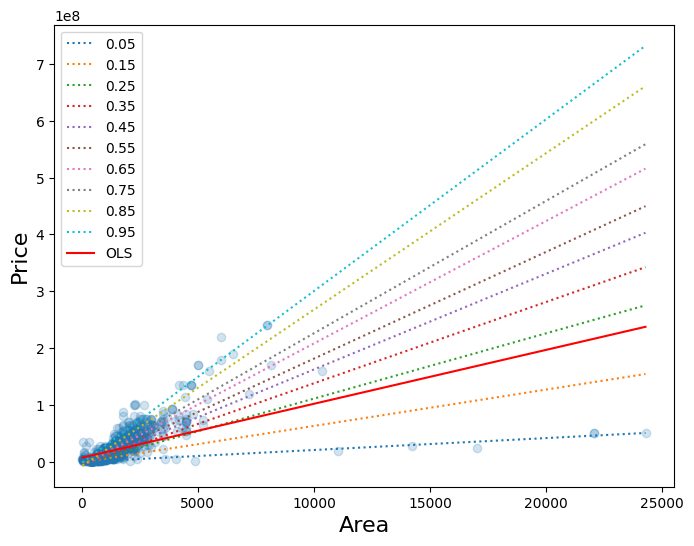

In [ ]:
x = np.arange(house_data.Area.min(), house_data.Area.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', label= str(round(0.05 + i*0.1, 2)))

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(house_data.Area, house_data.Price, alpha=.2)
legend = ax.legend()
ax.set_xlabel('Area', fontsize=16)
ax.set_ylabel('Price', fontsize=16);

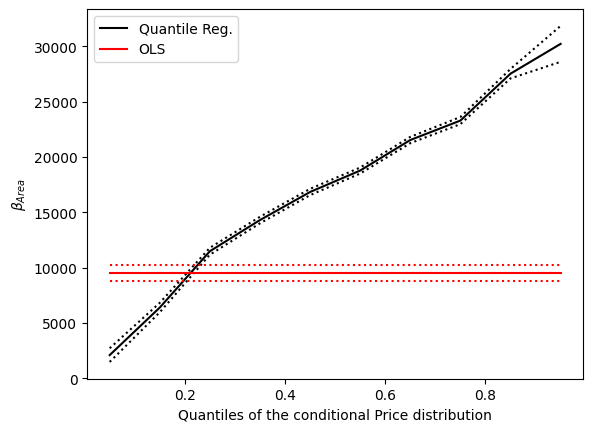

In [ ]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{Area}$')
plt.xlabel('Quantiles of the conditional Price distribution')
plt.legend()
plt.show()

# Deep Qauntile Regression - mcycle(keras)

---
*   https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
*   **Keras** : https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb
*   **TensorFlow - simultaneous multiple Quantiles** : https://github.com/strongio/quantile-regression-tensorflow/blob/master/Quantile%20Loss.ipynb



\begin{align}
\mathcal{L}(\xi_i|\alpha)=\begin{cases}
\alpha \xi_i &\text{if }\xi_i\ge 0, \\
(\alpha-1) \xi_i &\text{if }\xi_i< 0.
\end{cases}
\end{align}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras.backend as K

## 2.1. Data Prep

In [ ]:
mcycle = pd.read_csv('/content/gdrive/MyDrive/cdw_temp/mcycle.csv')

In [ ]:
mcycle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   times   133 non-null    float64
 1   accel   133 non-null    float64
dtypes: float64(2)
memory usage: 2.2 KB


In [ ]:
mcycle.times = (mcycle.times - mcycle.times.mean())/mcycle.times.std()
mcycle.accel = (mcycle.accel - mcycle.accel.mean())/mcycle.accel.std()

In [ ]:
mcycle

,times,accel
0,-1.734605,0.528659
1,-1.719376,0.501756
2,-1.673686,0.472783
3,-1.643226,0.528659
4,-1.612766,0.472783
...,...,...
128,2.133789,0.224450
129,2.270858,0.472783
130,2.270858,0.750090
131,2.301318,0.472783


## 2.2. Analysis

### 2.2.1. Regression

In [ ]:
model = Sequential()
model.add(Dense(units=10, input_dim=1,activation='relu'))
model.add(Dense(units=10, input_dim=1,activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adadelta')
model.fit(mcycle.times.values, mcycle.accel.values, epochs=2000, batch_size=32, verbose=0)
model.evaluate(mcycle.times.values, mcycle.accel.values)

5/5 [==============================] - 0s 3ms/step - loss: 0.7362


0.736239492893219

7/7 [==============================] - 0s 2ms/step


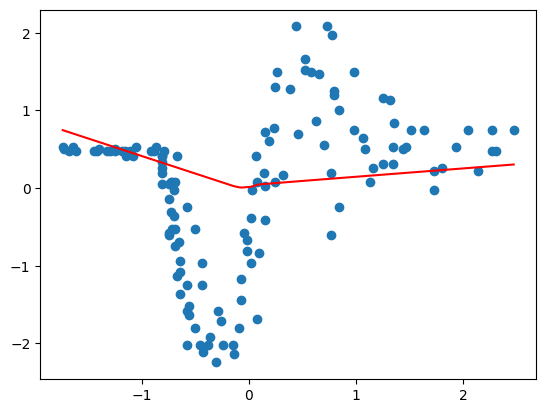

In [ ]:
t_test = np.linspace(mcycle.times.min(),mcycle.times.max(),200)
y_test = model.predict(t_test)

plt.scatter(mcycle.times,mcycle.accel)
plt.plot(t_test, y_test,'r')
plt.show()

### 2.2.2. Qauntiles

In [ ]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [ ]:
def mcycleModel():
    model = Sequential()
    model.add(Dense(units=10, input_dim=1,activation='relu'))
    model.add(Dense(units=10, input_dim=1,activation='relu'))
    model.add(Dense(1))

    return model

7/7 [==============================] - 0s 2ms/step


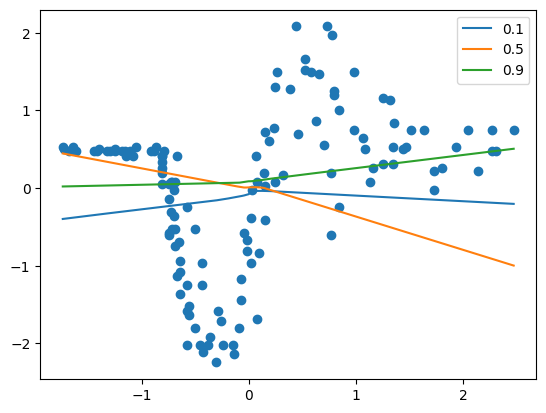

In [ ]:
qs = [0.1, 0.5, 0.9]

t_test = np.linspace(mcycle.times.min(),mcycle.times.max(),200)
plt.scatter(mcycle.times,mcycle.accel)

for q in qs:
    model = mcycleModel()
    model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adadelta')
    model.fit(mcycle.times.values, mcycle.accel.values, epochs=2000, batch_size=32, verbose=0)

    # Predict the quantile
    y_test = model.predict(t_test)
    plt.plot(t_test, y_test, label=q) # plot out this quantile

plt.legend()
plt.show()

# Deep simultaneous Multiple Qauntile Regression - mcycle(Tensorflow)

---
*   **TensorFlow - simultaneous multiple Quantiles** : https://github.com/strongio/quantile-regression-tensorflow/blob/master/Quantile%20Loss.ipynb



In [ ]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

# Initialize session
sess = tf.Session()

In [ ]:
# Reshape to input format for network
times = np.expand_dims(mcycle.times.values, 1)
accel = np.expand_dims(mcycle.accel.values, 1)

In [ ]:
# Create network
class q_model:
    def __init__(self,
                 sess,
                 quantiles,
                 in_shape=1,
                 out_shape=1,
                 batch_size=32):

        self.sess = sess

        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)

        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size

        self.outputs = []
        self.losses = []
        self.loss_history = []

        self.build_model()

    def build_model(self, scope='q_model', reuse=tf.AUTO_REUSE):
        with tf.variable_scope(scope, reuse=reuse) as scope:
            self.x = tf.placeholder(tf.float32, shape=(None, self.in_shape))
            self.y = tf.placeholder(tf.float32, shape=(None, self.out_shape))

            self.layer0 = tf.layers.dense(self.x,
                                    units=32,
                                    activation=tf.nn.relu)
            self.layer1 = tf.layers.dense(self.layer0,
                                    units=32,
                                    activation=tf.nn.relu)

            # Create outputs and losses for all quantiles
            for i in range(self.num_quantiles):
                q = self.quantiles[i]

                # Get output layers
                output = tf.layers.dense(self.layer1, 1, name="{}_q{}".format(i, int(q*100)))
                self.outputs.append(output)

                # Create losses

                error = tf.subtract(self.y, output)
                loss = tf.reduce_mean(tf.maximum(q*error, (q-1)*error), axis=-1)

                self.losses.append(loss)

            # Create combined loss
            self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
            self.train_step = tf.train.AdamOptimizer().minimize(self.combined_loss)

    def fit(self, x, y, epochs=100):
        for epoch in range(epochs):
            epoch_losses = []
            for idx in range(0, x.shape[0], self.batch_size):
                batch_x = x[idx : min(idx + self.batch_size, x.shape[0]),:]
                batch_y = y[idx : min(idx + self.batch_size, y.shape[0]),:]

                feed_dict = {self.x: batch_x,
                             self.y: batch_y}

                _, c_loss = self.sess.run([self.train_step, self.combined_loss], feed_dict)
                epoch_losses.append(c_loss)

            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if epoch % 100 == 0:
                print("Epoch {}: {}".format(epoch, epoch_loss))

    def predict(self, x):
        # Run model to get outputs
        feed_dict = {self.x: x}
        predictions = sess.run(self.outputs, feed_dict)

        return predictions

In [ ]:
# Instantiate model
quantiles = [.1, .5, .9]
model = q_model(sess, quantiles, batch_size=32)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

<ipython-input-53-09c0e72307ff>:30: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.layer0 = tf.layers.dense(self.x,
<ipython-input-53-09c0e72307ff>:33: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.layer1 = tf.layers.dense(self.layer0,
<ipython-input-53-09c0e72307ff>:42: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  output = tf.layers.dense(self.layer1, 1, name="{}_q{}".format(i, int(q*100)))


In [ ]:
# Run training
epochs = 2000
model.fit(times, accel, epochs)

Epoch 0: 1.0804436206817627
Epoch 100: 0.4903991222381592
Epoch 200: 0.3463827669620514
Epoch 300: 0.301912397146225
Epoch 400: 0.2801547646522522
Epoch 500: 0.27034372091293335
Epoch 600: 0.2659328579902649
Epoch 700: 0.26398181915283203
Epoch 800: 0.25801271200180054
Epoch 900: 0.2577058672904968
Epoch 1000: 0.2557450234889984
Epoch 1100: 0.25535935163497925
Epoch 1200: 0.2537357211112976
Epoch 1300: 0.2558597922325134
Epoch 1400: 0.2533196806907654
Epoch 1500: 0.25115182995796204
Epoch 1600: 0.2520262598991394
Epoch 1700: 0.2512257397174835
Epoch 1800: 0.2504505515098572
Epoch 1900: 0.25189486145973206


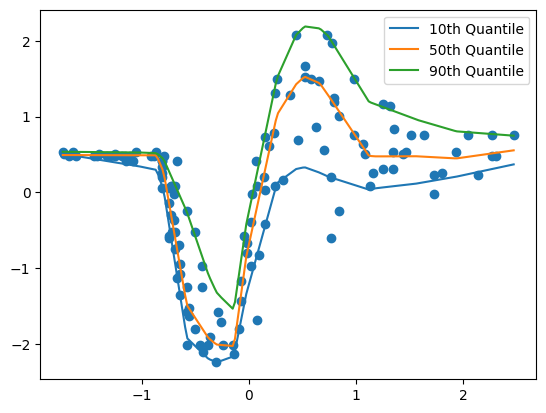

In [ ]:
# Generate the range of data we'd like to predict
test_times = np.expand_dims(np.linspace(times.min(),times.max(),200), 1)
predictions = model.predict(test_times)

plt.scatter(times, accel)
for i, prediction in enumerate(predictions):
    plt.plot(test_times, prediction, label='{}th Quantile'.format(int(model.quantiles[i]*100)))

plt.legend()
plt.show()